In [114]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from cassandra.io.geventreactor import GeventConnection
from cassandra.cluster import Cluster
import os
import csv
from thefuzz import fuzz
from thefuzz import process


import pandas as pd
from cassandra.cluster import Cluster
from cassandra.query import BatchStatement
import os
# Connect to Cassandra
cluster = Cluster(['127.0.0.1'])
session = cluster.connect('university')

In [18]:


# Data Cleaning and Transformation
def clean_and_transform(file_paths):
    all_dfs = []  # List to store dataframes from all files

    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path)

            # Convert price fields
            df['original_price'] = pd.to_numeric(df['original_price'].str.replace('£', ''), errors='coerce')
            df['discounted_price'] = pd.to_numeric(df['discounted_price'].str.replace('£', ''), errors='coerce')

            # Extract discount percentage
            df['discount_percentage'] = pd.to_numeric(df['discount'].str.replace('%', ''), errors='coerce')
            df['discount_percentage'] = df['discount_percentage'].astype(int)
            # Convert date_recorded to datetime
            df['date_recorded'] = pd.to_datetime(df['date_recorded']).dt.strftime('%Y-%m-%d %H:%M:%S')
            df['date_recorded'] = pd.to_datetime(df['date_recorded'])
            # Expand platforms field into separate rows
            df['platforms'] = df['platforms'].str.strip("[]").str.replace("'", "")
            expanded_df = df.drop('platforms', axis=1).join(
                df['platforms'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).rename('platform')
            )

            all_dfs.append(expanded_df)
        except Exception as e:
            print(f"{file_path} error")
    # Combine all dataframes into one
    combined_df = pd.concat(all_dfs, ignore_index=True)

    return combined_df
 

In [19]:
directory_path = r"C:\\Users\\guymf\Desktop\\DataSet"
file_paths = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.csv')]

cleaned_data = clean_and_transform(file_paths)


C:\\Users\\guymf\Desktop\\DataSet\playstationData2.csv error
C:\\Users\\guymf\Desktop\\DataSet\playstationData3.csv error


In [20]:
# cleaned_data
cleaned_data

,name,original_price,discounted_price,discount,product_type,rank_in_sale,sale_name,date_recorded,discount_percentage,platform
0,Luckslinger,7.99,4.39,-45%,FULL_GAME,2001,WM_EU_DEALS,2022-07-22,-45,PS4
1,Sparkle 4 Tales,7.99,0.79,-90%,FULL_GAME,2002,WM_EU_DEALS,2022-07-22,-90,PS4
2,BLUE REFLECTION: Bath Towels Complete Set,18.99,9.49,-50%,ADD_ON_PACK,2003,WM_EU_DEALS,2022-07-22,-50,PS4
3,Penarium,7.39,1.47,-80%,DEMO,2004,WM_EU_DEALS,2022-07-22,-80,PS4
4,Chime Sharp,7.99,3.99,-50%,FULL_GAME,2005,WM_EU_DEALS,2022-07-22,-50,PS4
...,...,...,...,...,...,...,...,...,...,...
99,DEEMO -Reborn- Eshen Chen Collection Vol.1: Tr...,3.99,1.59,-60%,LEVEL,2098,WM_EU_DEALS,2022-07-22,-60,PS4
100,Mortal Blitz : Combat Arena - 25+3 Arena Packs,19.99,7.99,-60%,ITEM,2099,WM_EU_DEALS,2022-07-22,-60,
101,Mortal Blitz: Combat Arena - 2 Arena Packs,1.69,0.67,-60%,ITEM,2100,WM_EU_DEALS,2022-07-22,-60,
102,The Metronomicon - Chiptune Challenge Pack 1,1.69,0.59,-65%,LEVEL,2101,WM_EU_DEALS,2022-07-22,-65,PS4


Python scripts to ingest the dataset into your Cassandra database

In [21]:

def ingest_to_cassandra(df, keyspace, table):
    keyspace = "university"
    table = "game_deals"
    cluster = Cluster(['127.0.0.1'])
    session = cluster.connect(keyspace)

    insert_statement = session.prepare(f"""
        INSERT INTO {table} (game_title, platform, original_price, discounted_price, 
                             discount_percentage, product_type, rank_in_sale, sale_name, date_recorded)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
    """)

    batch = BatchStatement()
    for index, row in df.iterrows():
        batch.add(insert_statement, (row['name'], row['platform'], row['original_price'], 
                                     row['discounted_price'], row['discount_percentage'], 
                                     row['product_type'], row['rank_in_sale'], 
                                     row['sale_name'], row['date_recorded']))

    session.execute(batch)
    session.shutdown()
    print("Data ingestion completed.")



In [22]:
ingest_to_cassandra(cleaned_data, 'university', 'game_deals')



Data ingestion completed.


Data Analysis: 

Query 1: Find the Average Discount Percentage by Platform

In [25]:
from collections import defaultdict

# Fetching platform and discount_percentage for all entries
query1 = "SELECT platform, discount_percentage FROM game_deals"
rows = session.execute(query1)

# Using defaultdict to store discount percentages for each platform
discounts_by_platform = defaultdict(list)

for row in rows:
    discounts_by_platform[row.platform].append(row.discount_percentage)

# Calculating the average discount percentage for each platform
avg_discounts_by_platform = {platform: sum(discounts) / len(discounts) 
                             for platform, discounts in discounts_by_platform.items()}

for platform, avg_discount in avg_discounts_by_platform.items():
    print(platform, avg_discount)


 -60.0
PS4 -56.189473684210526
PS5 -50.0


  Platform  Average Discount
0                 -60.000000
1      PS4        -56.189474
2      PS5        -50.000000


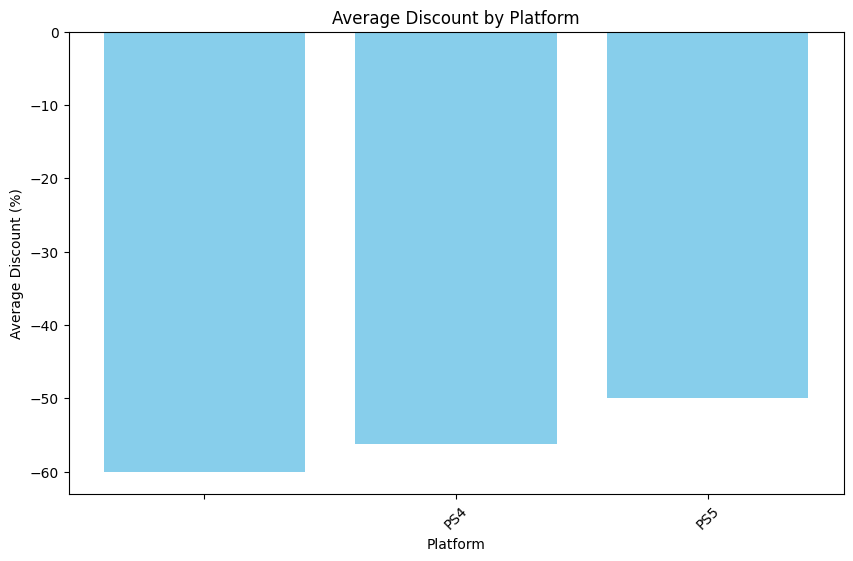

In [120]:


df_discounts = pd.DataFrame(list(avg_discounts_by_platform.items()), columns=['Platform', 'Average Discount'])

print(df_discounts)



# Plotting the average discounts by platform
plt.figure(figsize=(10, 6))
plt.bar(df_discounts['Platform'], df_discounts['Average Discount'], color='skyblue')
plt.xlabel('Platform')
plt.ylabel('Average Discount (%)')
plt.title('Average Discount by Platform')
plt.xticks(rotation=45)
plt.show()




Query 2: Compare Original and Discounted Prices for a Specific Platform


In [137]:
# Fetching the data without ORDER BY
query = """
SELECT sale_name, platform, original_price, discounted_price, discount_percentage, date_recorded
FROM game_deals
WHERE sale_name = 'WM_EU_DEALS' ALLOW FILTERING;
"""
rows = session.execute(query)

# Convert to a list of dictionaries to sort in Python
games = [{
    'game_name': row.sale_name,
    'platform': row.platform,
    'original_price': row.original_price,
    'discounted_price': row.discounted_price,
    'discount_percentage': row.discount_percentage,
    'date_recorded': row.date_recorded
} for row in rows]

# Sort the list by discount_percentage
sorted_games = sorted(games, key=lambda x: x['discounted_price'], reverse=True)

# Print or process the sorted list as needed
for game in sorted_games[:20]:  # Assuming you want the top 5
    print(game)


{'game_name': 'WM_EU_DEALS', 'platform': 'PS4', 'original_price': Decimal('15.9900000000000002131628207280300557613372802734375'), 'discounted_price': Decimal('11.1899999999999995026200849679298698902130126953125'), 'discount_percentage': -30, 'date_recorded': datetime.datetime(2022, 7, 22, 0, 0)}
{'game_name': 'WM_EU_DEALS', 'platform': 'PS5', 'original_price': Decimal('15.9900000000000002131628207280300557613372802734375'), 'discounted_price': Decimal('11.1899999999999995026200849679298698902130126953125'), 'discount_percentage': -30, 'date_recorded': datetime.datetime(2022, 7, 22, 0, 0)}
{'game_name': 'WM_EU_DEALS', 'platform': 'PS4', 'original_price': Decimal('18.989999999999998436805981327779591083526611328125'), 'discounted_price': Decimal('9.4900000000000002131628207280300557613372802734375'), 'discount_percentage': -50, 'date_recorded': datetime.datetime(2022, 7, 22, 0, 0)}
{'game_name': 'WM_EU_DEALS', 'platform': '', 'original_price': Decimal('19.989999999999998436805981327779

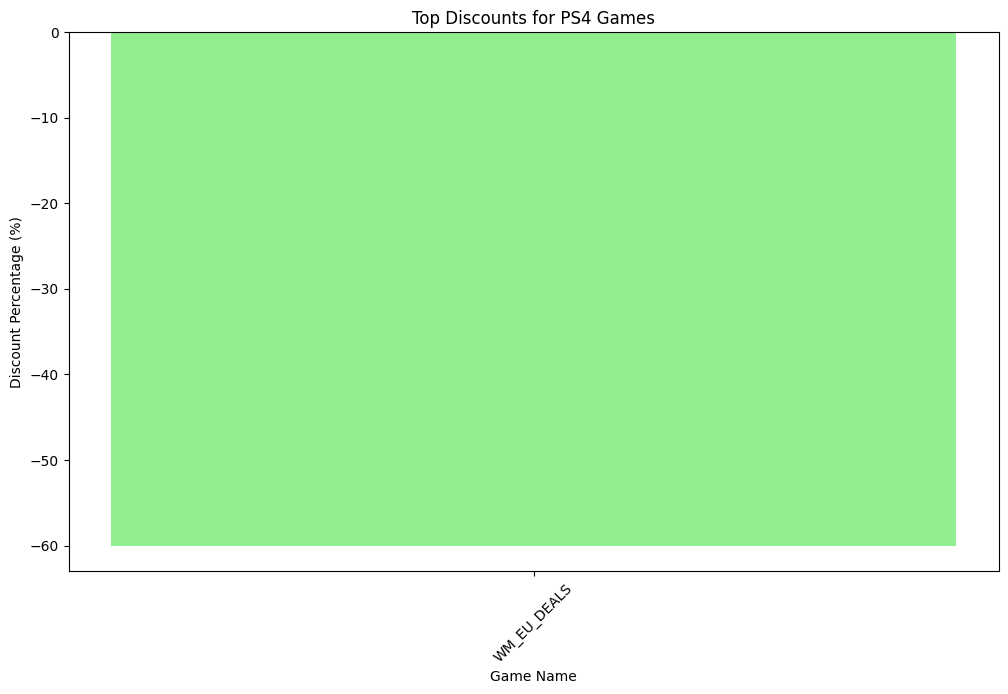

In [138]:
# Converting the sorted list of games into a DataFrame
df_games = pd.DataFrame(sorted_games)
# Assuming you're interested in the top 5 games only
plt.figure(figsize=(12, 7))
plt.bar(df_games['game_name'][:5], df_games['discount_percentage'][:5], color='lightgreen')
plt.xlabel('Game Name')
plt.ylabel('Discount Percentage (%)')
plt.title('Top Discounts for PS4 Games')
plt.xticks(rotation=45)
plt.show()


Query 3: Get Discount Avrage

In [150]:
def get_discount_trends_by_product_type(product_type, start_date):
    query = f"""SELECT date_recorded, AVG(discount_percentage) as average_discount
    FROM game_deals
    WHERE product_type = '{product_type}' AND date_recorded >= '{start_date}'
    GROUP BY date_recorded
    ALLOW FILTERING;"""
    try:
        result = session.execute(query)
        df = result._current_rows
        return df
    except Exception as e:
        print(f"Error executing query: {e}")



In [151]:
results = get_discount_trends_by_product_type("ADD_ON_PACK", "2022-07-22")
for row in results:
    print(f"Date Recorded: {row.date_recorded}, Average Discount: {row.average_discount}%")


Date Recorded: 2022-07-22 00:00:00, Average Discount: -49%


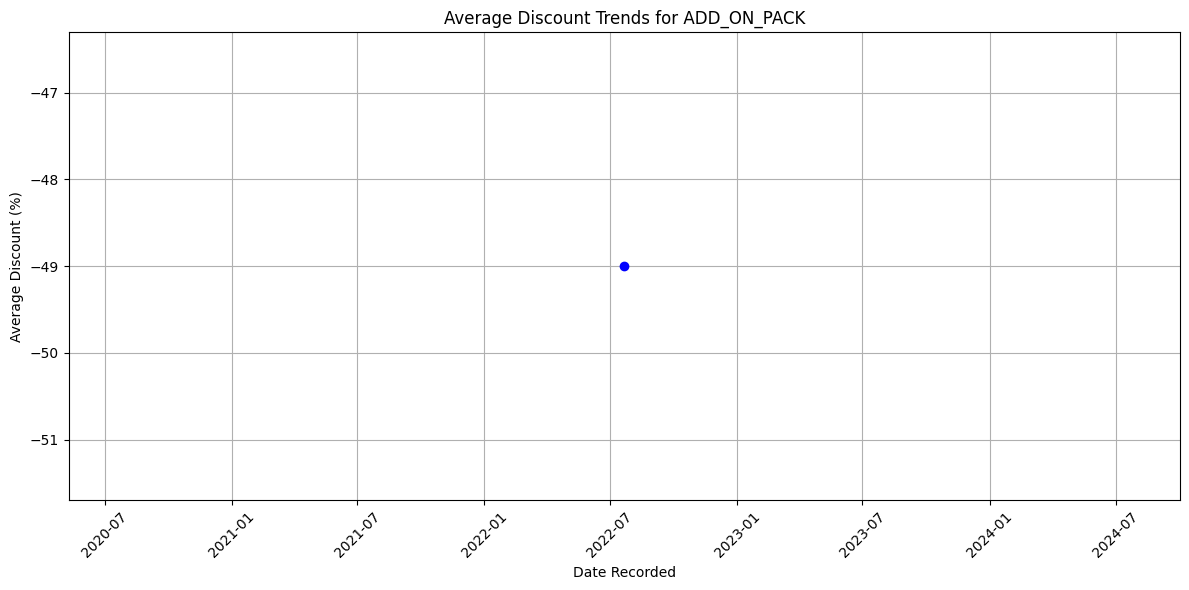

In [154]:
import pandas as pd

# Convert query results to DataFrame
df_trends = pd.DataFrame([{
    'Date Recorded': row.date_recorded,
    'Average Discount': row.average_discount
} for row in results])

# Ensure 'Date Recorded' is in datetime format for better plotting
df_trends['Date Recorded'] = pd.to_datetime(df_trends['Date Recorded'])

plt.figure(figsize=(12, 6))
plt.plot(df_trends['Date Recorded'], df_trends['Average Discount'], marker='o', linestyle='-', color='blue')
plt.title('Average Discount Trends for ADD_ON_PACK')
plt.xlabel('Date Recorded')
plt.ylabel('Average Discount (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjusts plot parameters to give some padding
plt.show()



Query 4: Get Top N Sales by Discount Percentage for a Specific Sale Name

In [88]:
def get_top_sales_by_discount_percentage(sale_name, top_n):
    query = f"""SELECT product_type, original_price, discounted_price, discount_percentage
    FROM game_deals
    WHERE sale_name = '{sale_name}'
    ALLOW FILTERING;"""
    try:
        result = session.execute(query)
        df = result._current_rows
        return df[:top_n]
    except Exception as e:
        print(f"Error executing query: {e}")




In [89]:
result = get_top_sales_by_discount_percentage("WM_EU_DEALS", 4)

In [90]:
result

[Row(product_type='LEVEL', original_price=Decimal('19.989999999999998436805981327779591083526611328125'), discounted_price=Decimal('7.9900000000000002131628207280300557613372802734375'), discount_percentage=-60),
 Row(product_type='ITEM', original_price=Decimal('19.989999999999998436805981327779591083526611328125'), discounted_price=Decimal('7.9900000000000002131628207280300557613372802734375'), discount_percentage=-60),
 Row(product_type='ITEM', original_price=Decimal('1.689999999999999946709294817992486059665679931640625'), discounted_price=Decimal('0.67000000000000003996802888650563545525074005126953125'), discount_percentage=-60),
 Row(product_type='FULL_GAME', original_price=Decimal('7.9900000000000002131628207280300557613372802734375'), discounted_price=Decimal('4.38999999999999968025576890795491635799407958984375'), discount_percentage=-45)]

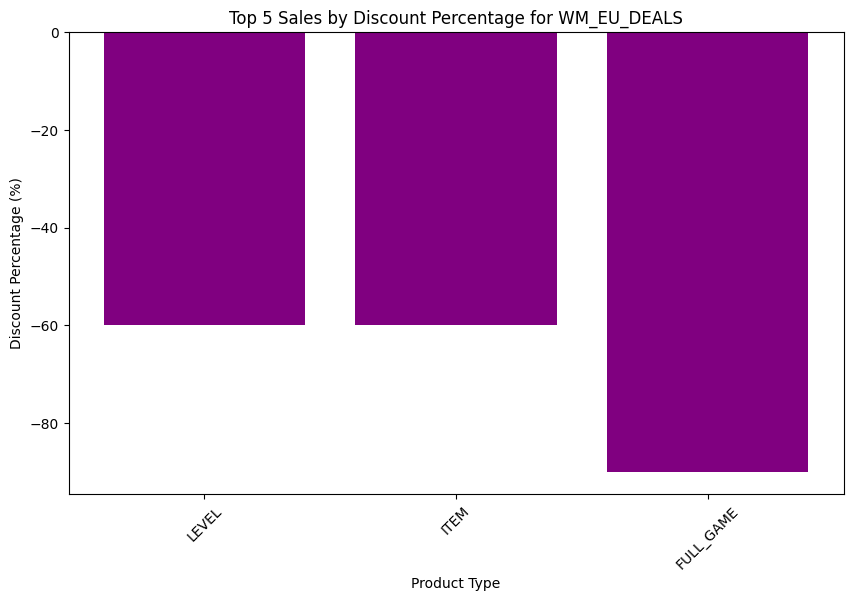

In [159]:
import pandas as pd

# Convert query results to DataFrame
df_sales = pd.DataFrame([{
    'Product Type': row.product_type,
    'Original Price': float(row.original_price),
    'Discounted Price': float(row.discounted_price),
    'Discount Percentage': row.discount_percentage
} for row in result])

plt.figure(figsize=(10, 6))
plt.bar(df_sales['Product Type'], df_sales['Discount Percentage'], color='purple')
plt.xlabel('Product Type')
plt.ylabel('Discount Percentage (%)')
plt.title(f'Top {len(df_sales)} Sales by Discount Percentage for WM_EU_DEALS')
plt.xticks(rotation=45)
plt.show()


Query 5: Top Discounts Price Offered Within a Specific Time Frame


In [162]:
def get_top_discounts(start_date, end_date, limit=10):
    query = f"""SELECT date_recorded, platform, product_type, original_price, discounted_price, discount_percentage
    FROM game_deals
    WHERE date_recorded >= '{start_date}' AND date_recorded <= '{end_date}'
    LIMIT {limit}
    ALLOW FILTERING;"""
    try:
        result = session.execute(query)
        return result._current_rows
    except Exception as e:
        print(f"Error executing query: {e}")

# Example usage
start_date = "2022-01-01"
end_date = "2022-07-22"
result = get_top_discounts(start_date, end_date, 5)


In [163]:
result

[Row(date_recorded=datetime.datetime(2022, 7, 22, 0, 0), platform='', product_type='LEVEL', original_price=Decimal('19.989999999999998436805981327779591083526611328125'), discounted_price=Decimal('7.9900000000000002131628207280300557613372802734375'), discount_percentage=-60),
 Row(date_recorded=datetime.datetime(2022, 7, 22, 0, 0), platform='', product_type='ITEM', original_price=Decimal('19.989999999999998436805981327779591083526611328125'), discounted_price=Decimal('7.9900000000000002131628207280300557613372802734375'), discount_percentage=-60),
 Row(date_recorded=datetime.datetime(2022, 7, 22, 0, 0), platform='', product_type='ITEM', original_price=Decimal('1.689999999999999946709294817992486059665679931640625'), discounted_price=Decimal('0.67000000000000003996802888650563545525074005126953125'), discount_percentage=-60),
 Row(date_recorded=datetime.datetime(2022, 7, 22, 0, 0), platform='PS4', product_type='FULL_GAME', original_price=Decimal('7.9900000000000002131628207280300557613

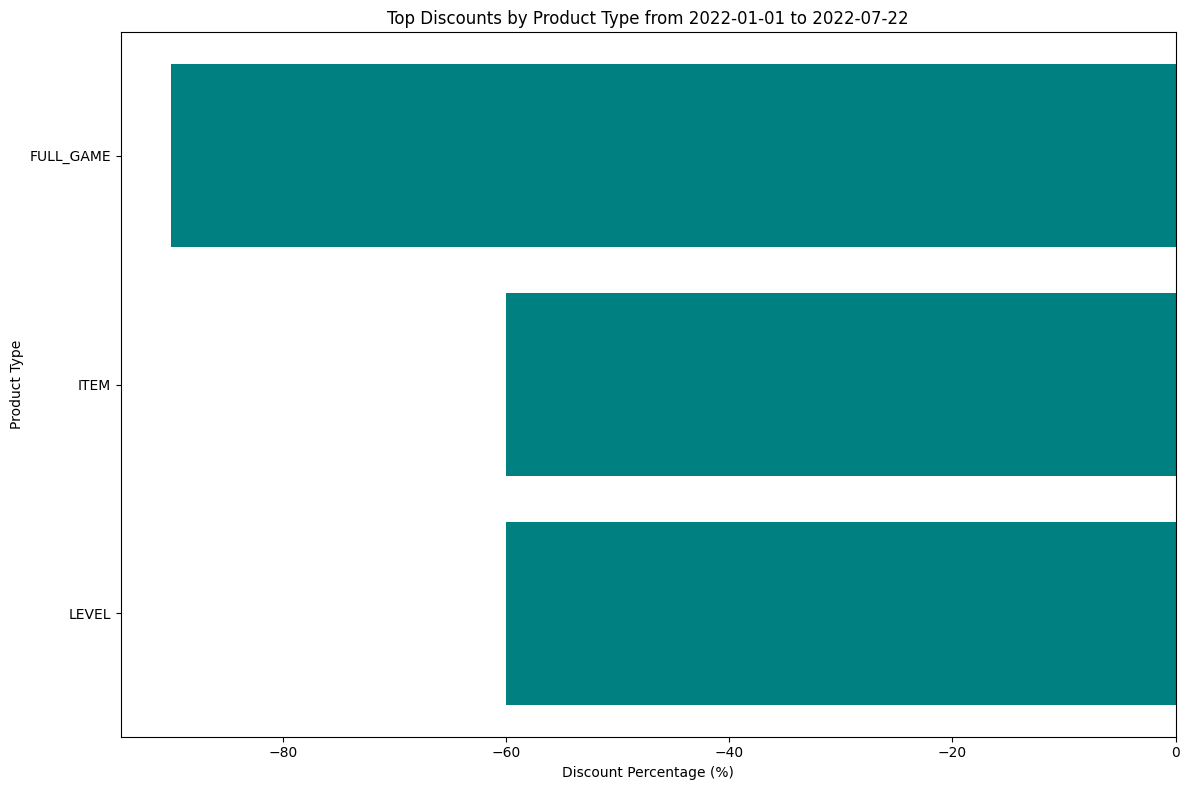

In [164]:

# Assuming `result` is the list of Row objects returned from the query
df_top_discounts = pd.DataFrame([{
    'Date Recorded': row.date_recorded,
    'Platform': row.platform,
    'Product Type': row.product_type,
    'Original Price': float(row.original_price),
    'Discounted Price': float(row.discounted_price),
    'Discount Percentage': row.discount_percentage
} for row in result])

# Convert 'Date Recorded' to a datetime format for easier plotting and analysis
df_top_discounts['Date Recorded'] = pd.to_datetime(df_top_discounts['Date Recorded'])

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(df_top_discounts['Product Type'], df_top_discounts['Discount Percentage'], color='teal')
plt.xlabel('Discount Percentage (%)')
plt.ylabel('Product Type')
plt.title('Top Discounts by Product Type from {} to {}'.format(start_date, end_date))
plt.tight_layout()
plt.show()
